### Introduction
This notebook explores fluorescence data as an example . We will process the dataset, apply feature selection methods, and perform predictions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from  encode import get_solution
from DT_sampler import DT_sampler
from sklearn.model_selection import train_test_split
from numpy import genfromtxt
import os

In [2]:
#print("cpu: ", os.uname()[1])
data = pd.read_csv('../data/fluorescence.csv', delimiter=',', header=None).to_numpy()   
X = data[:,:-1]
y = data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 100, random_state=42)
#print("X_train:", X_train.shape)
start = time.time()
# Generate "cnf" file.
cnf_path='../cnf/fluorescence_7_seed_42_threshold80.cnf'
#n_node=7,threshold=80
sol = get_solution(X_train, y_train, 7, 80, cnf_path, is_leaf_sampling=True)

### Feature Selection
In this section, we apply feature selection techniques to identify the most relevant features in the dataset. We calculate the feature importance by emergence probability.

{1: 0.027, 2: 0.033, 3: 0.34, 4: 0.04, 5: 0.333, 6: 0.013, 7: 0.027, 8: 0.007, 9: 0.033, 10: 0.053, 11: 0.013, 12: 0.047, 13: 0.033}


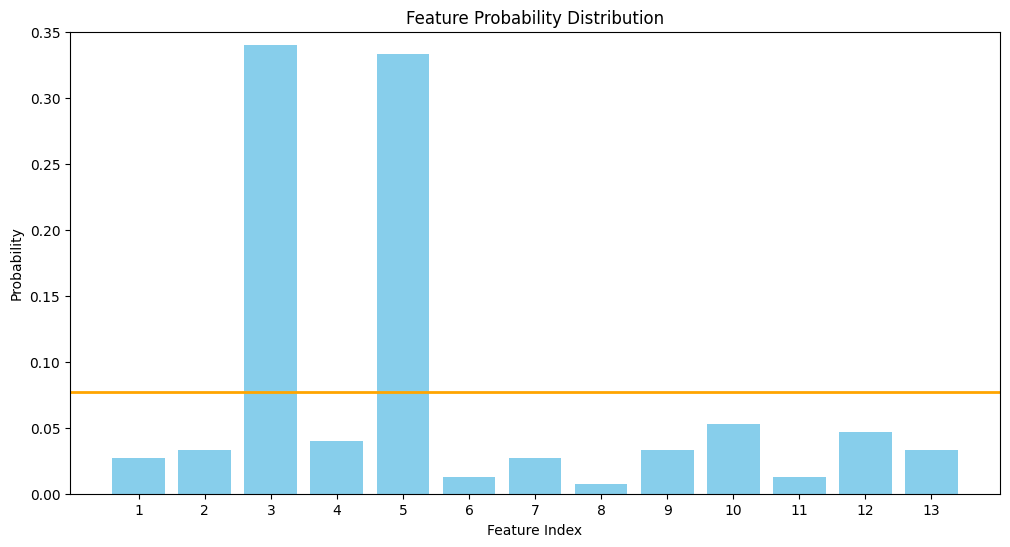

In [3]:
# Load fluorescence data
fluorescence_data = genfromtxt('../data/fluorescence.csv', delimiter=',')
X_all, y_all = fluorescence_data[:, :-1], np.int8(fluorescence_data[:, -1])
# Set a fixed random seed for the training data

X_tr, X, y_tr, labels = train_test_split(X_all, y_all, train_size=100, random_state=42)

cnf_path = "../cnf/fluorescence_7_seed_42_threshold80.cnf"
#sol = get_solution(X_train, y_train, 7, 80, cnf_path, is_leaf_sampling=True)
MARGIN=True
n_run=5
f_prob_list=[]
f_prob_CP_list=[]
alpha=0.2
err_all = []
acc_all = []
n_cal=200# number of calibration points
errors = []
accs = []
dt_sampler = DT_sampler(X_tr, y_tr, 7, threshold=80, cnf_path=cnf_path)
dt_sampler.run(50, method="unigen", sample_seed=0)
f_prob = dt_sampler.feature_prob()
print(f_prob)
n_feature=len(X_tr[0])

features = list(f_prob.keys())
prob_values = list(f_prob.values())
plt.figure(figsize=(12, 6))
plt.bar(features, prob_values, color='skyblue')
plt.xlabel('Feature Index')
plt.ylabel('Probability')
plt.xticks(features) 
plt.ylim(0, 0.35) 
plt.title('Feature Probability Distribution')
plt.axhline(y=1/n_feature, color='orange', linestyle='-', linewidth=2)
plt.show()

### Prediction

Random Forest

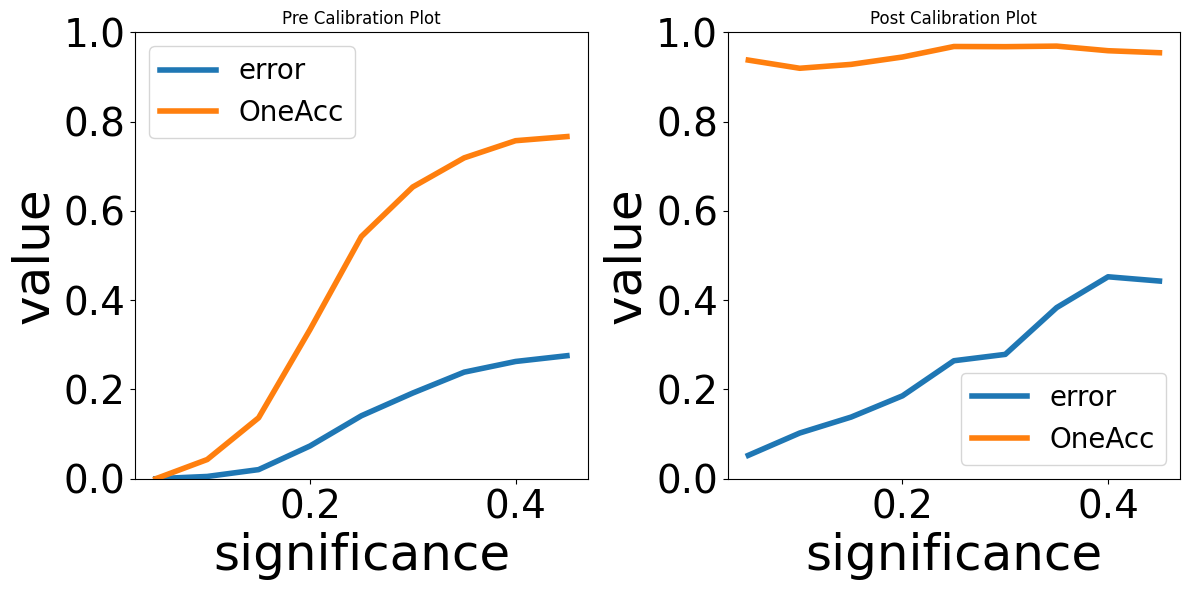

In [4]:
from sklearn.ensemble import RandomForestClassifier
# Given the score matrix "s" and the true class indices vector "l", the following method returns the margin values
def comp_margin(s, l):
    m, p = s.shape
    indx = np.zeros((m, p))
    indx[np.arange(m), l] = 1
    data_other_class = np.ma.array(s, mask=indx)
    data_true_class = np.ma.array(s, mask=~data_other_class.mask)
    s_other = data_other_class.compressed().reshape((m, p - 1))
    s_true = data_true_class.compressed().reshape((m, 1))
    margin = s_true - np.max(s_other, axis=1, keepdims=True)
    return margin


def nc_margin(s_cal, s_val, l):
    m_cal = comp_margin(s_cal, l)
    m_val = np.empty(s_val.shape)
    for j in range(s_val.shape[1]):
        m_val[:, j] = comp_margin(s_val, np.ones(s_val.shape[0], dtype=np.int8) * j).flatten()

    return m_cal, m_val

def calibrate_scores(smx, labels, alphas, n_calib=200, MARGIN=True, n_run=5):
    if smx.ndim == 3:
        errors_list = []
        accs_list = []
        n_models = smx.shape[2]
        for j in range(n_models):
            err_j, acc_j = calibrate_scores(smx[:, :, j], labels, alphas, n_calib, MARGIN, n_run)
            errors_list.append(err_j)
            accs_list.append(acc_j)
        errors = np.mean(errors_list, axis=0)
        accs = np.mean(accs_list, axis=0)
        return errors, accs

    errors = []
    accs = []
    
    for alpha in alphas:
        err_runs = []
        acc_runs = []
        
        for run in range(n_run):
            # Split the scores into calibration and validation sets (save the shuffling)
            idx = np.array([1] * n_calib + [0] * (smx.shape[0] - n_calib)) > 0
            np.random.shuffle(idx)
            cal_smx, val_smx = smx[idx, :], smx[~idx, :]
            cal_labels, val_labels = labels[idx], labels[~idx]
            # 1: get conformal scores. n = calib_Y.shape[0]
            if MARGIN:
                # Conformal scores using "margin
                cal_mgx, val_mgx = nc_margin(cal_smx, val_smx, cal_labels)
                cal_scores = 1 - cal_mgx
            else:
                cal_scores = 1 - cal_smx[np.arange(n_calib), cal_labels]
            # 2: get adjusted quantile
            q_level = np.ceil((n_calib + 1) * (1 - alpha)) / n_calib
            qhat = np.quantile(cal_scores, q_level, method='higher')
            # 3: form prediction sets
            if MARGIN:
                prediction_sets = val_mgx >= (1 - qhat) 
            else:
                prediction_sets = val_smx >= (1 - qhat)
            # Coverage
            empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]), val_labels].mean()
            # OneAcc
            ps = prediction_sets.sum(axis=1)
            idx_oneC = np.where(ps == 1)[0]
            if len(idx_oneC) == 0:
                one_class_accuracy = 0
            else:
                one_class_accuracy = prediction_sets[idx_oneC, val_labels[idx_oneC]].mean()
            
            err_runs.append(1 - empirical_coverage)
            acc_runs.append(one_class_accuracy)
        
        errors.append(np.mean(err_runs))
        accs.append(np.mean(acc_runs))
    
    return errors, accs


clf = RandomForestClassifier(n_estimators=100, max_depth=8,min_samples_leaf=0.01, random_state=None)
clf.fit(X_tr, y_tr)
trees = clf.estimators_

pred_all = np.empty((len(X), 2, len(trees)))
for i, tree in enumerate(trees):
    pred_all[:, :, i] = tree.predict_proba(X)
pred_all_tree = clf.predict_proba(X)

alphas = np.arange(0.05, 0.5, 0.05)
errors, accs = calibrate_scores(pred_all, labels, alphas, n_calib=200, MARGIN=True, n_run=5)
errors_tree, accs_tree = calibrate_scores(pred_all_tree, labels, alphas, n_calib=200, MARGIN=True, n_run=5)


title_fontsize = 28
label_fontsize = 36
tick_fontsize = 28
legend_fontsize = 20
line_width = 4

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(alphas, errors, label="error",linewidth=line_width)
ax1.plot(alphas, accs, label="OneAcc",linewidth=line_width)
ax1.set_xlabel("significance",fontdict={'size': label_fontsize})
ax1.set_ylabel("value",fontdict={'size': label_fontsize})
ax1.tick_params(axis='both', labelsize=tick_fontsize)
ax1.legend(fontsize=legend_fontsize)
ax1.set_title("Pre Calibration Plot")
ax1.set_ylim([0, 1])
ax2.plot(alphas, errors_tree, label="error",linewidth=line_width)
ax2.plot(alphas, accs_tree, label="OneAcc",linewidth=line_width)
ax2.set_xlabel("significance",fontdict={'size': label_fontsize,})
ax2.set_ylabel("value",fontdict={'size': label_fontsize})
ax2.tick_params(axis='both', labelsize=tick_fontsize)
ax2.legend(fontsize=legend_fontsize)
ax2.set_title("Post Calibration Plot")
ax2.set_ylim([0, 1])
plt.tight_layout()
plt.show()

DT-Sampler

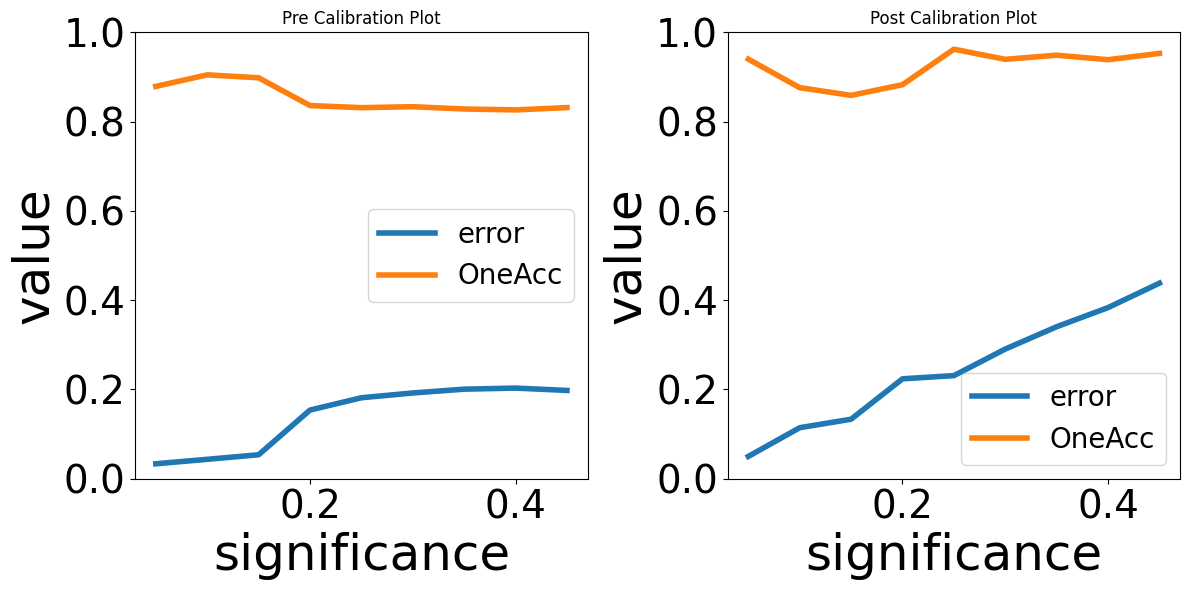

In [5]:
dt_sampler = DT_sampler(X_tr, y_tr, 7, threshold=80, cnf_path=cnf_path)
dt_sampler.run(50, method="unigen", sample_seed=0)
alphas = np.arange(0.05, 0.5, 0.05)
# Returns a 3D array containing probabilities of two classes for all 50 trees.
pred_all = dt_sampler.predict_proba_all_trees(X)
pred_all_tree = dt_sampler.predict_proba_ensemble(X)

errors, accs = calibrate_scores(pred_all, labels, alphas, n_calib=200, MARGIN=True, n_run=5)
errors_tree, accs_tree = calibrate_scores(pred_all_tree, labels, alphas, n_calib=200, MARGIN=True, n_run=5)

title_fontsize = 28
label_fontsize = 36
tick_fontsize = 28
legend_fontsize = 20
line_width = 4

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(alphas, errors, label="error",linewidth=line_width)
ax1.plot(alphas, accs, label="OneAcc",linewidth=line_width)
ax1.set_xlabel("significance",fontdict={'size': label_fontsize})
ax1.set_ylabel("value",fontdict={'size': label_fontsize})
ax1.tick_params(axis='both', labelsize=tick_fontsize)
ax1.legend(fontsize=legend_fontsize)
ax1.set_title("Pre Calibration Plot")
ax1.set_ylim([0, 1])
ax2.plot(alphas, errors_tree, label="error",linewidth=line_width)
ax2.plot(alphas, accs_tree, label="OneAcc",linewidth=line_width)
ax2.set_xlabel("significance",fontdict={'size': label_fontsize,})
ax2.set_ylabel("value",fontdict={'size': label_fontsize})
ax2.tick_params(axis='both', labelsize=tick_fontsize)
ax2.legend(fontsize=legend_fontsize)
ax2.set_title("Post Calibration Plot")
ax2.set_ylim([0, 1])
plt.tight_layout()
plt.show()